In [1]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product

sns.set_style('whitegrid')

# sns.set_context('notebook')

# %matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'
import sys
sys.path.insert(0, '/home/ubuntu/results/inpca')

from utils import get_data, get_idx

from plot import plot3d, triplot
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

In [2]:
colors = """
 aliceblue, antiquewhite, aqua, aquamarine, azure,
                beige, bisque, black, blanchedalmond, blue,
                blueviolet, brown, burlywood, cadetblue,
                chartreuse, chocolate, coral, cornflowerblue,
                cornsilk, crimson, cyan, darkblue, darkcyan,
                darkgoldenrod, darkgray, darkgrey, darkgreen,
                darkkhaki, darkmagenta, darkolivegreen, darkorange,
                darkorchid, darkred, darksalmon, darkseagreen,
                darkslateblue, darkslategray, darkslategrey,
                darkturquoise, darkviolet, deeppink, deepskyblue,
                dimgray, dimgrey, dodgerblue, firebrick,
                floralwhite, forestgreen, fuchsia, gainsboro,
                ghostwhite, gold, goldenrod, gray, grey, green,
                greenyellow, honeydew, hotpink, indianred, indigo,
                ivory, khaki, lavender, lavenderblush, lawngreen,
                lemonchiffon, lightblue, lightcoral, lightcyan,
                lightgoldenrodyellow, lightgray, lightgrey,
                lightgreen, lightpink, lightsalmon, lightseagreen,
                lightskyblue, lightslategray, lightslategrey,
                lightsteelblue, lightyellow, lime, limegreen,
                linen, magenta, maroon, mediumaquamarine,
                mediumblue, mediumorchid, mediumpurple,
                mediumseagreen, mediumslateblue, mediumspringgreen,
                mediumturquoise, mediumvioletred, midnightblue,
                mintcream, mistyrose, moccasin, navajowhite, navy,
                oldlace, olive, olivedrab, orange, orangered,
                orchid, palegoldenrod, palegreen, paleturquoise,
                palevioletred, papayawhip, peachpuff, peru, pink,
                plum, powderblue, purple, red, rosybrown,
                royalblue, saddlebrown, salmon, sandybrown,
                seagreen, seashell, sienna, silver, skyblue,
                slateblue, slategray, slategrey, snow, springgreen,
                steelblue, tan, teal, thistle, tomato, turquoise,
                violet, wheat, white, whitesmoke, yellow,
                yellowgreen"""
colors = [c.strip() for c in colors.split(',')]
np.random.shuffle(colors)
colors = ["darkred", "blue", "turquoise", "green", "gold", "purple"]
symbols = ['circle', 'cross', 'diamond',
            'square', 'x']

In [3]:
dist = th.load('/home/ubuntu/results/inpca/inpca_results_avg/dists_pointwise_yh.p')
didx = th.load('/home/ubuntu/results/inpca/inpca_results_avg/didx_pointwise_yh.p').reset_index()

In [4]:
chunks = np.array_split(np.arange(2538), 50)
for i in range(46, len(chunks)):
    for j in range(i+1, len(chunks)):
        i1 = chunks[i]
        i2 = chunks[j]
        dist[i2[0]:i2[-1]+1, i1[0]:i1[-1]+1] = dist[i1[0]:i1[-1]+1, i2[0]:i2[-1]+1].T
th.save(dist, '/home/ubuntu/results/inpca/inpca_results_avg/dists_pointwise_yh.p')

In [5]:
from embed import proj_
idx = get_idx(didx, "aug == 'simple' and err<0.2")
w = dist[:, idx][idx, :]
l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l / 2
r = proj_(w, len(idx), 2)


Projecting


In [6]:
didx_ = didx.iloc[idx]
for i in range(3):
    didx_ = didx_.assign(**{f"x{i+1}":r['xp'][:, i]}) 
didx_ = didx_.assign(avg=lambda x: x.seed < 0)

In [7]:
didx_['size'] = didx_['avg'].map({False: 4, True: 8})
models = didx_['m'].unique()
opts = didx_['opt'].unique()
cdict = {m: colors[i] for (i, m) in enumerate(models)}
c = didx_.m.map(cdict)
sdict = {o: symbols[i] for (i, o) in enumerate(opts)}
s = didx_.opt.map(sdict)


In [8]:
for col in ['seed', 'm', 'opt', 'err', 'verr', 'bs', 'lr', 'wd']:
    didx_[col] = f'{col}: ' + didx_[col].astype(str)
text = didx_[['seed', 'm', 'opt', 'err', 'verr', 
           'bs', 'lr', 'wd']].apply("<br>".join, axis=1)
text = 't: ' + didx_['t'].astype(str) + '<br>' + text
fig = go.Figure(data=[go.Scatter3d(
    x=didx_.x1,  # ie [0, 1, 2, 3]
    y=didx_.x2,  # ie [0, 1, 2, 3]
    z=didx_.x3,  # ie [0, 1, 2, 3]
    hovertemplate='<b>%{text}</b><extra></extra>',
    text=text,
    mode='markers',
    marker=dict(
        size=didx_['size'],
        opacity=0.8,
        symbol=s,
        color=c,
    )
)])

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)

fig.show()
print(r['e'])


[ 1.13346221e+03  3.63047059e+02  2.34175031e+02 -1.77045171e+01
 -1.38421024e+00 -9.03719043e-01 -3.84572061e-01]


<AxesSubplot:>

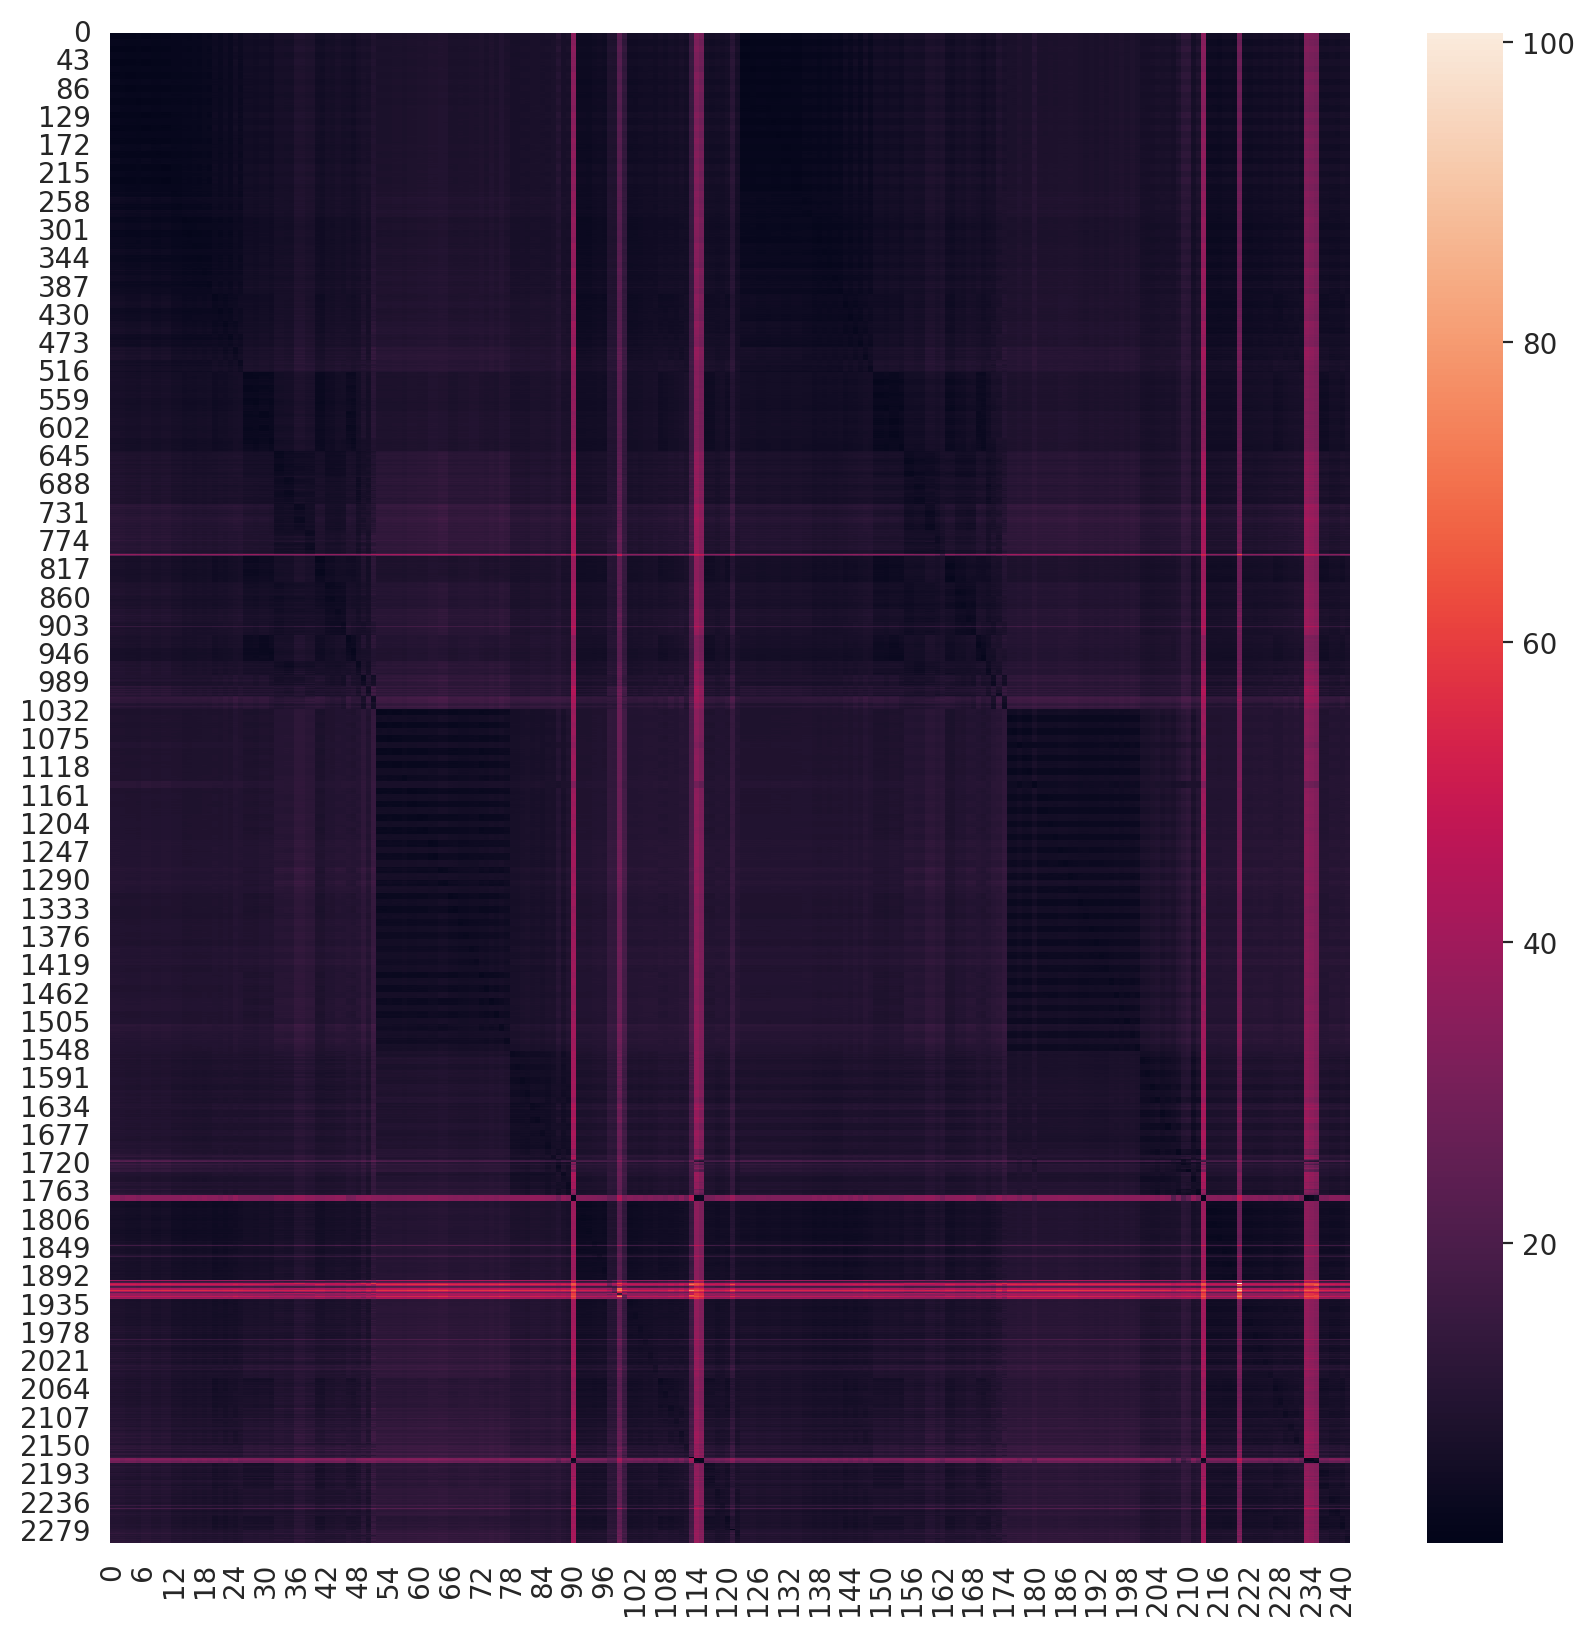

In [58]:
idx = []
names = []
didx_=didx[didx['seed']>0]
avg_idx = get_idx(didx, "seed < 0")
configs = didx_.groupby(['m', 'opt', 'bs', 'lr', 'wd', 'aug']).indices
for (k, v) in configs.items():
    idx.extend(v)
    for i in range(len(v)):
        names.append(k) 
sns.heatmap(pd.DataFrame(dist[idx, :][:, avg_idx]))

In [18]:
import torch.nn.functional as F
def plot_pairwise_dist(dists, configs, 
                    cconds=[lambda x: True], 
                    rconds=[lambda x: True], 
                    sortby=1, reduction='avg_pool2d', annot=False,
                    xblock_size=10, yblock_size=1, 
                    label_idxs=slice(0,-1),
                    square=False, return_didx=False):
    cidxs = []
    ridxs = []
    columns = []
    rows = []
    if square:
        rconds = cconds
        yblock_size = xblock_size
    if cconds or rconds:
        for (i, c) in configs.iterrows():
            if cconds and all(f(c) for f in cconds):
                cidxs.append(i)
                columns.append(c)
            if rconds and all(f(c) for f in rconds):
                ridxs.append(i)
                rows.append(c)
    else:
        cidxs, ridxs = range(len(configs)), range(len(configs))
        columns, rows = configs, configs
    cidxs, ridxs = np.array(cidxs), np.array(ridxs)
    columns, rows = np.stack(columns), np.stack(rows)
    cidxs = cidxs[np.lexsort(columns[:, sortby:sortby+1].T)]
    columns = columns[np.lexsort(columns[:, sortby:sortby+1].T), label_idxs]
    ridxs = ridxs[np.lexsort(rows[:, sortby:sortby+1].T)]
    rows = rows[np.lexsort(rows[:, sortby:sortby+1].T), label_idxs]
    didxs=dists[:, cidxs][ridxs]
    if reduction:
        didxs = getattr(F, reduction)(th.Tensor(didxs).unsqueeze(0).unsqueeze(0), 
                        kernel_size=(yblock_size, xblock_size),
                        stride=(yblock_size, xblock_size)).squeeze().numpy()
        columns = columns[::xblock_size]
        rows = rows[::yblock_size]
    if return_didx:
        return didxs, rows, columns
    
    if reduction:
        ax = sns.heatmap(pd.DataFrame(didxs, columns=columns, index=rows), annot=annot, fmt='.2g')
    else:
        ax = sns.heatmap(pd.DataFrame(didxs, columns=columns, index=rows), 
                    xticklabels=xblock_size, yticklabels=yblock_size, annot=annot, fmt='.2g')
    return ax, didxs, rows, columns


In [100]:
idx = get_idx(didx, "aug == 'simple' and err<0.2 and bs == 200 and wd == 0.0 and m != 'fc'")
didx_ = didx.iloc[idx]
didx_ = didx_.assign(avg=lambda x: x.seed < 0)

In [101]:
indices = didx_.groupby(['m', 'opt', 'lr', 'wd']).indices

In [102]:
tuple(didx_.loc[5, ['m', 'opt', 'lr', 'wd']]) == ('allcnn', 'sgd', 0.1, 0.0)


True

In [103]:
df = []
for (c, ii) in indices.items():
    d_ = didx_.iloc[ii]
    avg_idx = d_[d_['avg'] == True].index
    dists = dist[avg_idx, :]
    for jj in idx:
        m = tuple(didx_.loc[jj, ['m', 'opt', 'lr', 'wd']])
        if m == c:
            df.append({'cavg': str(c), 'cm': 'same', 'dist': dists[:, jj]})
        else:
            df.append({'cavg': str(c), 'cm': m[0], 'dist': dists[:, jj]})
df = pd.DataFrame(df)

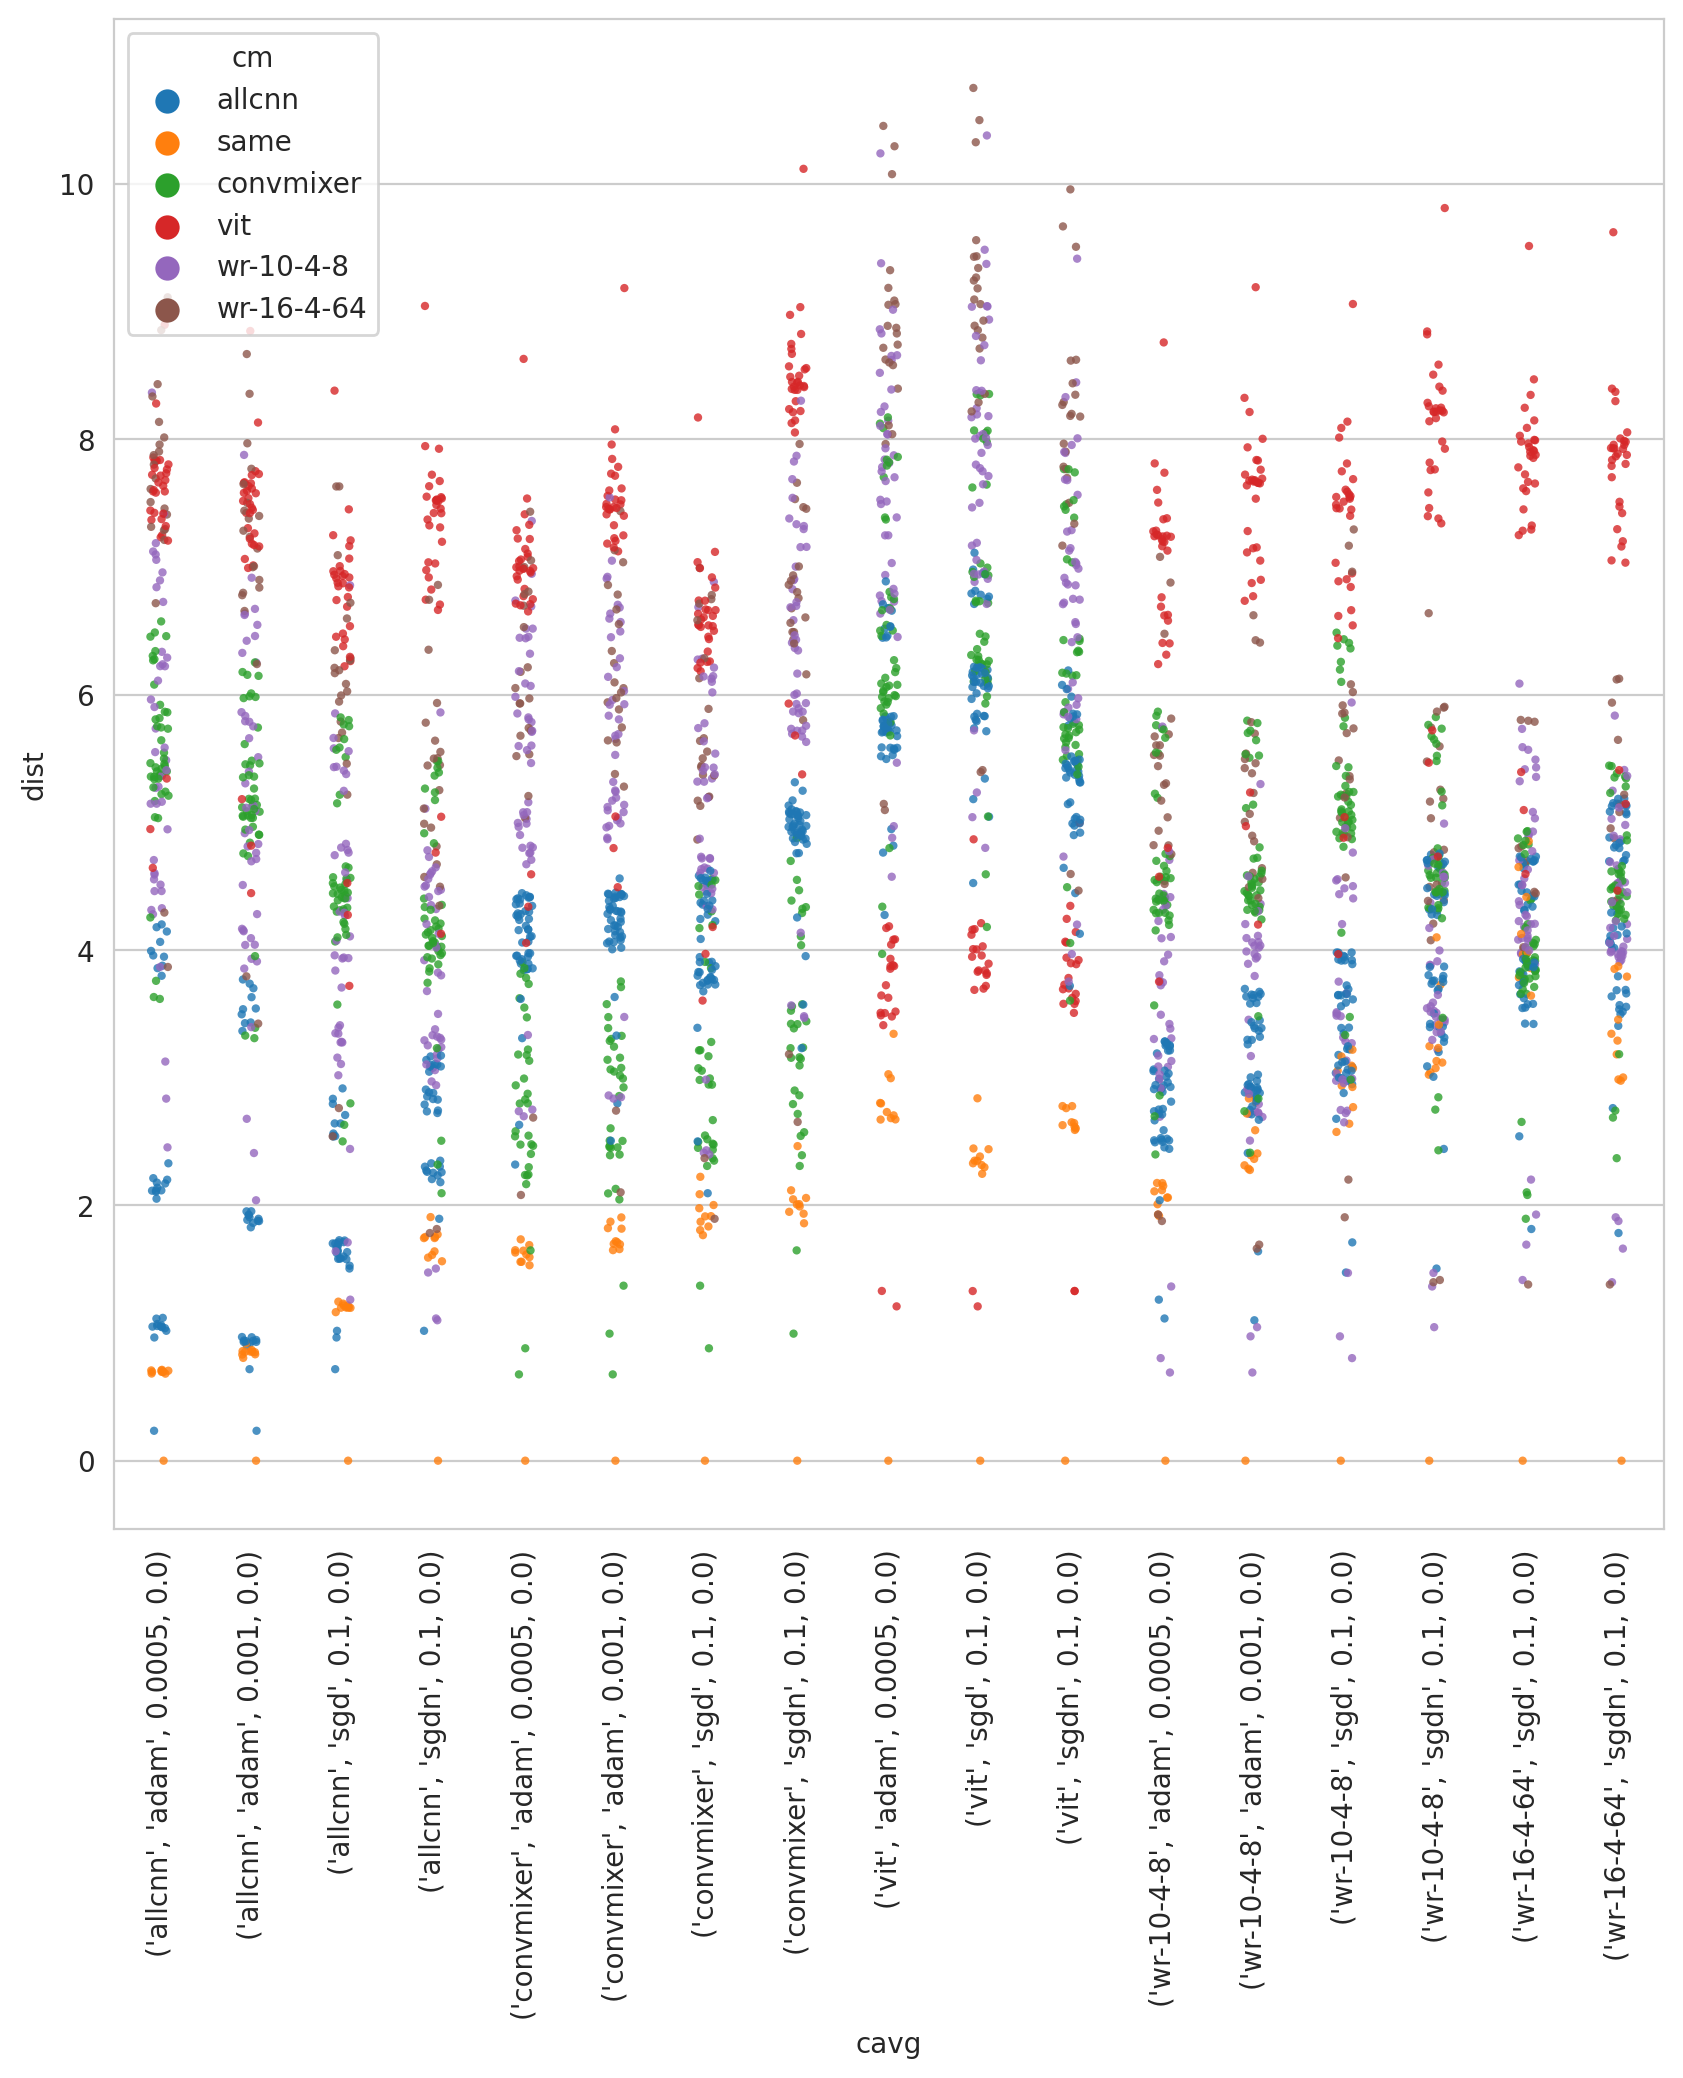

In [104]:
ax = sns.stripplot(data=df, x='cavg', y='dist', hue='cm', alpha=.8, size=3)
xtick = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)